In [63]:
import pandas as pd
# import modin.pandas as mpd
import numpy as np
import datetime
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import mplfinance as mpf
from multiprocessing import Pool
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import clear_output
# import dill as pickle
import pickle
import time

In [64]:
# causis api
from causis_api.const import get_version
from causis_api.const import login
login.username = 'shuai.song'
login.password = 'Tsinghua2022'
login.version = get_version()
from causis_api.data import *
from causis_api.tool import *

### Data Preparation

In [65]:
commodities = {
            'rb':{'multiplier':10,'mintick':1,'exchange':'SHF'},
            'hc':{'multiplier':10,'mintick':1,'exchange':'SHF'},
            'i':{'multiplier':100,'mintick':0.5,'exchange':'DCE'},
            'm':{'multiplier':10,'mintick':1,'exchange':'DCE'},
            'pp':{'multiplier':5,'mintick':1,'exchange':'DCE'},
            'MA':{'multiplier':10,'mintick':1,'exchange':'CZC'},
            'bu':{'multiplier':10,'mintick':2,'exchange':'SHF'},
            'l':{'multiplier':5,'mintick':5,'exchange':'DCE'},
            'p':{'multiplier':10,'mintick':2,'exchange':'DCE'},
            'v':{'multiplier':5,'mintick':5,'exchange':'DCE'},
            'CF':{'multiplier':5,'mintick':5,'exchange':'CZC'},
            'OI':{'multiplier':10,'mintick':1,'exchange':'CZC'},
            'SR':{'multiplier':10,'mintick':1,'exchange':'CZC'},
            'TA':{'multiplier':5,'mintick':2,'exchange':'CZC'},
            'SA':{'multiplier':20,'mintick':1,'exchange':'CZC'},
} 

In [115]:
Periods_5min = []
F_data_5min = {}

Periods_D = []
F_data_D = {}
for symbol in tqdm(commodities.keys(), desc='Data Accessing'):
    c = f"R.CN.{commodities[symbol]['exchange']}.{symbol}.0004"

    com_5min = get_price(c, '2010-01-01', '2022-06-25', 'minute5')
    com_5min[['OPEN', 'HIGH', 'CLOSE', 'LOW']] = com_5min[['OPEN', 'HIGH', 'CLOSE', 'LOW']].astype('float64')
    com_5min[['SYMBOL', 'CLOCK']] =  com_5min[['SYMBOL', 'CLOCK']].astype('string')
    Periods_5min.append((com_5min['CLOCK'].iloc[0], com_5min['CLOCK'].iloc[-1]))
    F_data_5min[symbol] = com_5min

    com_D = get_price(c, '2010-01-01', '2022-06-25')
    com_D[['OPEN', 'HIGH', 'CLOSE', 'LOW']] = com_D[['OPEN', 'HIGH', 'CLOSE', 'LOW']].astype('float64')
    com_D[['SYMBOL', 'CLOCK']] =  com_D[['SYMBOL', 'CLOCK']].astype('string')
    Periods_D.append((com_D['CLOCK'].iloc[0], com_D['CLOCK'].iloc[-1]))
    F_data_D[symbol] = com_D

with open('./dataset/F_data_5min.pkl', 'wb') as f:
    pickle.dump(F_data_5min, f)

with open('./dataset/F_data_D.pkl', 'wb') as f:
    pickle.dump(F_data_D, f)

Data Accessing: 100%|██████████| 15/15 [01:28<00:00,  5.92s/it]


In [116]:
F_data_5min = pd.read_pickle('./dataset/F_data_5min.pkl')
F_data_D = pd.read_pickle('./dataset/F_data_D.pkl')

Try Diffierent Timeframes:
+ 1 minutes: there may be more trading opportunities while also exits more noise. It's always okay if we can grab the correct opportunity ~5min later. But it's overwhelming to trigger a wrong signal whose cost is at least 2*tick.
  

In [117]:
# 5 MINs
COM_5 = F_data_5min['rb']
COM_D = F_data_D['rb']

In [121]:
COM_5 = COM_5.set_index('CLOCK', drop=False)
COM_5 = COM_5.ffill()

COM_D = COM_D.set_index('CLOCK', drop=False)

In [122]:
COM_5['DATE'] = COM_5['CLOCK'].apply(lambda x: x[:10])

In [131]:
COM_5_VTD = []

for name, g in COM_5.groupby('DATE'):
    COM_5_VTD.append(name)

In [132]:
COM_5 = COM_5.set_index('CLOCK', drop=False)

### Double SuperTrend Strategy

#### Global Environment Variables

In [133]:
## Super Trend Indicator
ATR_WIN_S = 5
STD_MULTIPLIER_S = 2

ATR_WIN_L = 10
STD_MULTIPLIER_L = 3

## BackTest & Simulation Parameters
ACCOUNT = 1e6
REWARD_RATIO = 0.15

## Plot Settings
COLORS = ['darkorange', 'cyan', 'royalblue', 'deeppink', 'indianred', 'limegreen']

In [134]:
@contextmanager 
def timer(name: str, _align, _log): # ⏱
    s = time.time()
    yield
    elapsed = time.time() - s
    if _log:
        print(f"{ '[' + name + ']' :{_align}} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done | Using {elapsed: .3f} seconds")

In [135]:
def price_adj(stmp, PADJ):
    if PADJ:
        stmp['OPEN_adj'] = round(stmp['OPEN'] * stmp['ADJ'], 2)
        stmp['CLOSE_adj'] = round(stmp['CLOSE'] * stmp['ADJ'], 2)
        stmp['HIGH_adj'] = round(stmp['HIGH'] * stmp['ADJ'], 2)
        stmp['LOW_adj'] = round(stmp['LOW'] * stmp['ADJ'], 2)
    else:
        stmp['OPEN_adj'] = stmp['OPEN'] 
        stmp['CLOSE_adj'] = stmp['CLOSE'] 
        stmp['HIGH_adj'] = stmp['HIGH'] 
        stmp['LOW_adj'] = stmp['LOW'] 

    return stmp

In [138]:
def technical_analysis(stmp, log = True, PADJ=True):
    stmp = stmp.loc[~stmp['CLOCK'].duplicated()]
    stmp = price_adj(stmp.copy(deep=True), PADJ)

    with timer('Super Trend', 20, False):
        ## ATR
        def STD_CAL(atr_win, std_mul, _stmp):
            TR = []
            TR.append(_stmp['HIGH_adj'][0] - _stmp['LOW_adj'][0])
            for i in range(1, _stmp.shape[0]): 
                TR.append( max( _stmp['HIGH_adj'][i]-_stmp['LOW_adj'][i], np.abs(_stmp['HIGH_adj'][i]-_stmp['CLOSE_adj'][i-1]), np.abs(_stmp['LOW_adj'][i]-_stmp['CLOSE_adj'][i-1])) )

            _stmp['TR'] = TR
            _stmp['ATR'] = _stmp['TR'].rolling(atr_win, min_periods=1).mean() 

            ## Super Trend
            _stmp['h12'] = (_stmp['HIGH_adj'] + _stmp['LOW_adj'])/2
            _stmp['bub'] = _stmp['h12'] + std_mul*_stmp['ATR']
            _stmp['blb'] = _stmp['h12'] - std_mul*_stmp['ATR']

            UB = []
            LB = []
            UB.append(_stmp['bub'][0])
            LB.append(_stmp['blb'][0])

            for i in range(1, _stmp.shape[0]):
                if _stmp['CLOSE_adj'][i-1] > LB[i-1]:
                    LB.append(max(_stmp['blb'][i], LB[i-1]))
                else:
                    LB.append(_stmp['blb'][i])
                
                if _stmp['CLOSE'][i-1] < UB[i-1]:
                    UB.append(min(_stmp['bub'][i], UB[i-1]))
                else:
                    UB.append(_stmp['bub'][i])

            STD = []
            STD.append(np.sign(_stmp['CLOSE_adj'][0] - _stmp['OPEN_adj'][0]))

            for i in range(1, _stmp.shape[0]):
                if _stmp['CLOSE_adj'][i] > UB[i]:
                    STD.append(1.0)
                elif _stmp['CLOSE_adj'][i] < LB[i]:
                    STD.append(-1.0)
                else:
                    STD.append(STD[i-1])

            _stmp['UB'] = UB
            _stmp['LB'] = LB
            _stmp['STD'] = STD

            _stmp['UB'].loc[_stmp['STD']== 1.0] = np.nan # plot upper band during down trend
            _stmp['LB'].loc[_stmp['STD']==-1.0] = np.nan # plot lower band during up trend
            
            return _stmp['UB'], _stmp['LB'], _stmp['STD']
        
        with timer('Short Super Trend', 20, True):
            stmp['UB_S'], stmp['LB_S'], stmp['STD_S'] = STD_CAL(ATR_WIN_S, STD_MULTIPLIER_S, stmp.copy(deep=True))
            stmp['UB_S'].loc[stmp['STD_S']== 1.0] = np.nan # plot upper band during down trend
            stmp['LB_S'].loc[stmp['STD_S']==-1.0] = np.nan # plot lower band during up trend

        with timer('Long Super Trend', 20, True):
            stmp['UB_L'], stmp['LB_L'], stmp['STD_L'] = STD_CAL(ATR_WIN_L, STD_MULTIPLIER_L, stmp.copy(deep=True))
            stmp['UB_L'].loc[stmp['STD_L']== 1.0] = np.nan # plot upper band during down trend
            stmp['LB_L'].loc[stmp['STD_L']==-1.0] = np.nan # plot lower band during up trend
        
    return stmp

In [139]:
COM_5 = technical_analysis(COM_5, PADJ=False)

TypeError: abs() takes 1 positional argument but 2 were given

In [ ]:
COM_5.columns

Index(['SYMBOL', 'CLOCK', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'INTEREST',
       'SETTLE', 'ADJ', 'DATE', 'OPEN_adj', 'CLOSE_adj', 'HIGH_adj', 'LOW_adj',
       'UB_S', 'LB_S', 'STD_S', 'UB_L', 'LB_L', 'STD_L'],
      dtype='object')

Trigger:
+ BUY
  + S_STD turn red from green
  + The fork appears within Orange L_STD 
+ SELL
  + S_STD turn green from red
  + The fork appears within Purple L_STD 

In [ ]:
def Double_STD_trigger(stmp):
    tmp = 0.5*(2-np.abs(stmp['STD_S']+stmp['STD_S'].shift(1)))/stmp['STD_S']
    stmp['STD_S_Fork'] = tmp
    stmp['trigger'] = np.zeros(stmp.shape[0])
    
    buy_trigger_condition = (stmp['STD_S_Fork']== 1) & (stmp['STD_L']== 1) 
    stmp['trigger'].loc[buy_trigger_condition] = 1

    sell_trigger_condition = (stmp['STD_S_Fork']==-1) & (stmp['STD_L']==-1)
    stmp['trigger'].loc[sell_trigger_condition] = -1
   
    return stmp

In [ ]:
COM_5 =  Double_STD_trigger(COM_5)

In [ ]:
COM_5['trigger'].loc[COM_5['trigger']!=0]

CLOCK
2010-01-05 14:30:00   -1.0
2010-01-06 09:20:00    1.0
2010-01-07 09:05:00    1.0
2010-01-07 10:05:00   -1.0
2010-01-08 10:05:00   -1.0
                      ... 
2022-06-21 21:05:00    1.0
2022-06-21 23:00:00   -1.0
2022-06-22 14:50:00   -1.0
2022-06-24 11:30:00   -1.0
2022-06-24 14:35:00   -1.0
Name: trigger, Length: 2983, dtype: float64

#### Simulation

In [ ]:
TICK = 1.5

In [ ]:
BUY_trigger_list = list(COM_5['trigger'].loc[COM_5['trigger']== 1].index)
SELL_trigger_list = list(COM_5['trigger'].loc[COM_5['trigger']==-1].index)

BUY_log = pd.DataFrame(columns=['open_bar', 'close_bar', 'open_price', 'close_price', 'close_reason'])
clock_rank = COM_5['CLOCK'].to_list()
cal_count = 0

# for t in tqdm(BUY_trigger_list[:], desc='BUY Simulation'):
for i in range(len(BUY_trigger_list)):
    if i >= len(BUY_trigger_list):
        break
    t = BUY_trigger_list[i]
    cal_count += 1
    if cal_count % 10 == 1:
        process = f'{cal_count}/{len(BUY_trigger_list)}'
        print(f"{'[' + process + ']' :12} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done ")
    if cal_count % 100 == 0:
        clear_output()

    open_bar = clock_rank[clock_rank.index(t)+1]
    open_price = COM_5['OPEN'].loc[open_bar] + TICK

    loss_cut = COM_5.loc[open_bar]['LB_S']
    profit_cut = COM_5.loc[open_bar]['OPEN'] * (1 + REWARD_RATIO) 

    if COM_5['CLOCK'].loc[t:].loc[COM_5['trigger']==-1].shape[0]: # fork change coming, interrupt the simulation
        close_bar =  clock_rank[min(clock_rank.index(COM_5['CLOCK'].loc[t:].loc[COM_5['trigger']== -1][0])+1, len(clock_rank)-1)]
    else:
        close_bar = clock_rank[-1]

    for i in range(1, int((pd.to_datetime(close_bar) - pd.to_datetime(t)).total_seconds()/60)):
        observation_bar = clock_rank[min(clock_rank.index(open_bar)+i, len(clock_rank)-1)]

        if observation_bar in BUY_trigger_list:
            loss_cut = COM_5.loc[observation_bar]['LB_S']
            del BUY_trigger_list[BUY_trigger_list.index(observation_bar)]

        if observation_bar in SELL_trigger_list:
            loss_cut = COM_5.loc[observation_bar]['UB_S']            

        if (COM_5['LOW'].loc[observation_bar] <= loss_cut):
            close_bar = clock_rank[clock_rank.index(observation_bar)+1]
            close_reason = 'Loss_Cut'
            break

        if (COM_5['HIGH'].loc[observation_bar] >= profit_cut):
            close_bar = clock_rank[clock_rank.index(observation_bar)+1]
            close_reason = 'Profit_Cut'
            break

    close_price = COM_5['OPEN'].loc[close_bar] - TICK

    BUY_log.loc[BUY_log.shape[0]] = [open_bar, close_bar, open_price, close_price, close_reason]

[1001/1118]  | 2022-08-18 16:22:56 Done 
[1011/1113]  | 2022-08-18 16:22:57 Done 
[1021/1109]  | 2022-08-18 16:22:59 Done 
[1031/1106]  | 2022-08-18 16:23:00 Done 
[1041/1100]  | 2022-08-18 16:23:03 Done 
[1051/1096]  | 2022-08-18 16:23:06 Done 
[1061/1094]  | 2022-08-18 16:23:08 Done 
[1071/1090]  | 2022-08-18 16:23:10 Done 
[1081/1086]  | 2022-08-18 16:23:12 Done 


In [ ]:
BUY_log['gain'] = BUY_log['close_price'] - BUY_log['open_price']

In [ ]:
BUY_log['gain'].loc[BUY_log['gain']>0].shape[0]/BUY_log.shape[0]

0.2915129151291513

In [ ]:
BUY_log.loc[BUY_log['close_reason']=='Profit_Cut']

,open_bar,close_bar,open_price,close_price,close_reason,gain
450,2016-04-18 09:10:00,2016-04-21 09:05:00,2358.5,2698.5,Profit_Cut,340.0


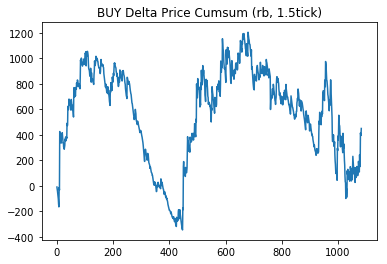

In [ ]:
plt.title('BUY Delta Price Cumsum (rb, 1.5tick)')
BUY_log['gain'].cumsum().plot()

In [ ]:
SELL_log = pd.DataFrame(columns=['open_bar', 'close_bar', 'open_price', 'close_price'])
clock_rank = COM_5['CLOCK'].to_list()
cal_count = 0

# for t in tqdm(BUY_trigger_list[:], desc='BUY Simulation'):
for i in range(len(SELL_trigger_list)):
    if i >= len(SELL_trigger_list):
        break
    t = SELL_trigger_list[i]
    cal_count += 1
    if cal_count % 10 == 1:
        process = f'{cal_count}/{len(SELL_trigger_list)}'
        print(f"{'[' + process + ']' :12} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done ")
    if cal_count % 100 == 0:
        clear_output()

    open_bar = clock_rank[clock_rank.index(t)+1]
    open_price = COM_5['OPEN'].loc[open_bar] - TICK

    loss_cut = COM_5.loc[open_bar]['UB_S']
    profit_cut = COM_5.loc[open_bar]['OPEN'] * (1 - REWARD_RATIO) 

    if COM_5['CLOCK'].loc[t:].loc[COM_5['trigger']== 1].shape[0]: # fork change coming, interrupt the simulation
        close_bar =  clock_rank[min(clock_rank.index(COM_5['CLOCK'].loc[t:].loc[COM_5['trigger']== 1][0])+1, len(clock_rank)-1)]
    else:
        close_bar = clock_rank[-1]

    for i in range(1, int((pd.to_datetime(close_bar) - pd.to_datetime(t)).total_seconds()/60)):
        observation_bar = clock_rank[min(clock_rank.index(open_bar)+i, len(clock_rank)-1)]

        if observation_bar in SELL_trigger_list:
            loss_cut = COM_5.loc[observation_bar]['UB_S']
            del SELL_trigger_list[SELL_trigger_list.index(observation_bar)]

        if observation_bar in BUY_trigger_list:
            loss_cut = COM_5.loc[observation_bar]['LB_S']            

        if (COM_5['HIGH'].loc[observation_bar] >= loss_cut) or (COM_5['LOW'].loc[observation_bar] <= profit_cut):
            close_bar = clock_rank[clock_rank.index(observation_bar)+1]
            break

    close_price = COM_5['OPEN'].loc[close_bar] + TICK

    SELL_log.loc[SELL_log.shape[0]] = [open_bar, close_bar, open_price, close_price]

[1101/1132]  | 2022-08-18 16:27:02 Done 
[1111/1127]  | 2022-08-18 16:27:04 Done 
[1121/1121]  | 2022-08-18 16:27:07 Done 


In [ ]:
SELL_log['gain'] = SELL_log['open_price'] - SELL_log['close_price']

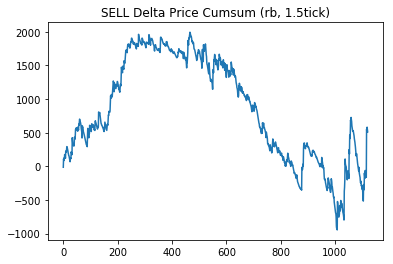

In [ ]:
plt.title("SELL Delta Price Cumsum (rb, 1.5tick)")
SELL_log['gain'].cumsum().plot()

In [ ]:
SELL_log['signal']= 'SELL'
BUY_log['signal'] = 'BUY'

buy = BUY_log.set_index('open_bar', drop=False)
sell = SELL_log.set_index('open_bar', drop=False)
trading_log = buy.append(sell)
trading_log = trading_log.sort_index()

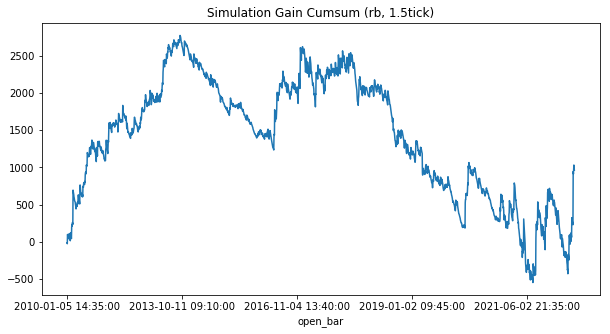

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.title('Simulation Gain Cumsum (rb, 1.5tick)')
trading_log['gain'].cumsum().plot()

### BackTest

In [ ]:
Dominant = get_dominant_contracts('R.CN.SHF.rb.0004', COM_5_VTD[0], COM_5_VTD[-1])

Dominant['last_dc'] = Dominant['ProductCode'].shift(1)
Dominant['Date'] = Dominant['Date'].apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:8])

In [ ]:
dc_change = Dominant.loc[(Dominant['ProductCode']!=Dominant['last_dc'])][1:]

In [ ]:
INIT_CAP = 1e8

In [ ]:
trading_log['open_bar'][11][:10]

def Date_Belong(clock):
    if clock[11:] < '21:00:00':
        return clock[:10]
    else:
        return COM_5_VTD[min(COM_5_VTD.index(clock[:10])+1, len(COM_5_VTD)-1)]

trading_log['open_date'] = trading_log['open_bar'].apply(lambda x: Date_Belong(x))
trading_log['close_date'] = trading_log['close_bar'].apply(lambda x: Date_Belong(x))

In [ ]:
# ## Drop NaN error dates
# for d1 in trading_log.loc[trading_log['close_price'].apply(lambda x: np.isnan(x))].index:
#     trading_log.drop(d1, inplace=True)

# ## Drop Date collapse
# for d2 in trading_log.loc[trading_log['open_bar']<trading_log['close_bar'].shift(1)].index:
#     trading_log.drop(d2, inplace=True)

In [ ]:
Balance = pd.DataFrame()
Balance = Balance.reindex(COM_5_VTD)
Balance['Account']  = np.zeros(Balance.shape[0])
Balance['interday_profit'] = np.zeros(Balance.shape[0])
Balance['holding_profit'] = np.zeros(Balance.shape[0])
Balance['holding_pos'] = np.zeros(Balance.shape[0])
Balance['dc_change_gap'] = np.zeros(Balance.shape[0])

for i in tqdm(range(trading_log.shape[0]), desc='Simulation...'):
    entry = trading_log.iloc[i]

    if entry['open_date'] == entry['close_date']: # open and close position in the same day
        OPEN_POS_VOL = int(INIT_CAP/(entry['open_price']*commodities['rb']['multiplier'])) # setting the allocatable money
        Balance['interday_profit'].loc[entry['open_date']] += entry['gain'] * OPEN_POS_VOL * commodities['rb']['multiplier']

    else:# holding position for a period
        pos_dir = 1 if entry['signal'] == 'BUY' else -1
        OPEN_POS_VOL = int(INIT_CAP/(entry['open_price']*commodities['rb']['multiplier'])) 

        period_start = entry['open_date']
        period_end   = COM_5_VTD[COM_5_VTD.index(entry['close_date'])-1]

        # gain or loss caused by position open
        delta_price = COM_5['CLOSE'].loc[period_start+' 15:00:00'] - entry['open_price']
        Balance['holding_pos'].loc[entry['open_date']] = pos_dir * OPEN_POS_VOL
        Balance['holding_profit'].loc[entry['open_date']] += pos_dir * OPEN_POS_VOL * delta_price * commodities['rb']['multiplier']


        # holding period value fluctuation
        for i in range(COM_5_VTD.index(entry['open_date'])+1, COM_5_VTD.index(entry['close_date'])):
            delta_price = COM_5['CLOSE'].loc[COM_5_VTD[i]+' 15:00:00'] - COM_5['CLOSE'].loc[COM_5_VTD[i-1]+' 15:00:00'] 
            Balance['holding_pos'].loc[COM_5_VTD[i]] = pos_dir * OPEN_POS_VOL
            Balance['holding_profit'].loc[COM_5_VTD[i]] += pos_dir * OPEN_POS_VOL * delta_price * commodities['rb']['multiplier']

        delta_price = entry['close_price'] - COM_5['CLOSE'].loc[period_end+' 15:00:00']
        Balance['holding_pos'].loc[entry['close_date']] = pos_dir * OPEN_POS_VOL
        Balance['holding_profit'].loc[entry['close_date']] += pos_dir * OPEN_POS_VOL * delta_price * commodities['rb']['multiplier']

for i in tqdm(range(dc_change.shape[0]), desc='Dominant Contracts Change'):
    try:
        entry = dc_change.iloc[i]
        nc = get_price(entry['ProductCode'], entry['Date'], entry['Date'])
        np = nc['OPEN'] # new contract price

        oc = get_price(entry['last_dc'], entry['Date'], entry['Date'])
        op = oc['OPEN'] # old contract price

        Balance['dc_change_gap'].loc[entry['Date']] = (op - np)*Balance['holding_pos'].loc[entry['Date']]
    except:
        continue # some data is ommited which is not contained in COM_5 either, so just ignore them
 

Dominant Contracts Change: 100%|██████████| 37/37 [00:05<00:00,  6.23it/s]


In [ ]:
# dc change has no effect
Balance['holding_pos'].loc[(Balance['holding_pos']!=0) & (pd.Series(Balance.index).apply(lambda x: x in dc_change['Date'].to_list()))]

Series([], Name: holding_pos, dtype: float64)

In [ ]:
Balance['d_gain'] = Balance['interday_profit'] + Balance['holding_profit']
Balance['Pnl'] = Balance['d_gain'].cumsum()/INIT_CAP + 1

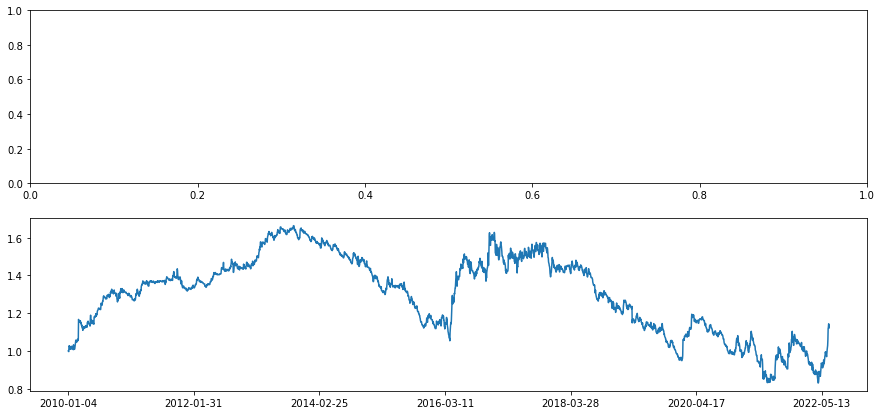

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
Balance['Pnl'].plot(ax = axes[1])

In [ ]:
trading_log['hold_t'] = (trading_log['close_bar'].apply(lambda x: pd.to_datetime(x))-trading_log['open_bar'].apply(lambda x: pd.to_datetime(x))).apply(lambda x: x.total_seconds()/60)

In [ ]:
trading_log['hold_t'].describe()

count      718.000000
mean      1869.435933
std       2419.118670
min          5.000000
25%        150.000000
50%       1152.500000
75%       2613.750000
max      17335.000000
Name: hold_t, dtype: float64

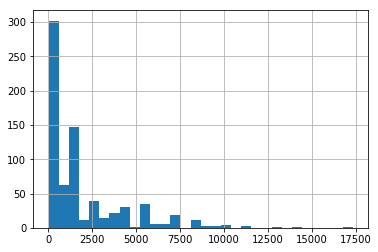

In [ ]:
trading_log['hold_t'].hist(bins=30)

In [ ]:
qc = 0
GN = 10
curs = []
for i in range(1, 1+GN):
    qc = i/10
    curs.append(int(trading_log['hold_t'].quantile(qc)))

curs = [0.] + curs

In [ ]:
curs

[0.0, 35, 85, 195, 313, 1152, 1430, 1678, 3161, 5523, 17335]

In [ ]:
def group(x):
    for i in range(GN):
        if (curs[i] < x) and (x <= curs[i+1]):
            return i + 1 

In [ ]:
trading_log['hold_t_g'] = trading_log['hold_t'].apply(lambda x: group(x))

In [ ]:
log_g = trading_log.groupby('hold_t_g')

In [ ]:
win_rate = []
win_loss_r = []
for id, df in log_g:
    win_rate.append(df.loc[df['gain']>0].shape[0] / df.shape[0])
    win_loss_r.append(-1 * df['gain'].loc[df['gain']>0].sum() / df['gain'].loc[df['gain']<0].sum())


In [ ]:
curs[1:]

[35, 85, 195, 313, 1152, 1430, 1678, 3161, 5523, 17335]

In [ ]:
win_rate

[0.0,
 0.0,
 0.013888888888888888,
 0.057971014492753624,
 0.09722222222222222,
 0.2191780821917808,
 0.4,
 0.625,
 0.4027777777777778,
 0.7361111111111112]

In [ ]:
win_loss_r

[0.0,
 0.0,
 0.00646900269541779,
 0.025448376151236064,
 0.07875833760903027,
 0.18669871794871795,
 1.302936630602782,
 4.886363636363637,
 3.316284317412561,
 3.7982921083627796]

In [ ]:
trading_log['hold_t'].quantile(1)

20885.0

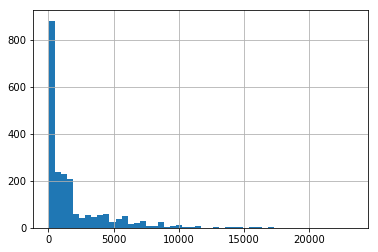

In [ ]:
trading_log['hold_t'].hist(bins=50)

### PLOT

In [ ]:
def plot_all(COM, t1, t2, PADJ=True):

    P_tmp = price_adj(COM.copy(deep=True), PADJ)

    smp_slice = P_tmp.loc[t1: t2]
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(50, 20), dpi=100, sharex=True)

    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dr'], color = 'red')
    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lr'], color = 'pink')
    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dg'], color = 'green')
    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lg'], color = 'lightgreen')

    # smp_slice['J'].plot(ax = axes[1], color='black')
    # axes[1].axhline(y=90, color='pink')
    # axes[1].axhline(y=10, color='pink')
    axes[1].bar(smp_slice['CLOCK'].to_list(), smp_slice['VOLUME'], color='purple', alpha=0.6)


    # RB['UB'].loc[RB['STD']==-1.0] = np.nan
    # RB['LB'].loc[RB['STD']==1.0] = np.nan
    smp_slice['UB_S'].plot(ax=axes[2], color='g', linewidth=3.5, linestyle='--')
    smp_slice['LB_S'].plot(ax=axes[2], color='r', linewidth=3.5, linestyle='--')

    smp_slice['UB_L'].plot(ax=axes[2], color='purple', linewidth=2.5, linestyle='-.')
    smp_slice['LB_L'].plot(ax=axes[2], color='orange', linewidth=2.5, linestyle='-.')

    # RB['CLOSE'].loc[180:280].plot(ax=axes, color='b')
    sdf = pd.DataFrame()
    sdf['CLOCK'] = smp_slice['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = smp_slice['OPEN_adj']
    sdf['Close'] = smp_slice['CLOSE_adj']
    sdf['High'] = smp_slice['HIGH_adj']
    sdf['Low'] = smp_slice['LOW_adj']
    sdf['Volume'] = smp_slice['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)

    mpf.plot(sdf, ax = axes[2], type='candle', style = s, ylabel='')

    # smp_slice['P_S_EMA'].plot(ax=axes[2], color='orange', alpha=0.6)
    # smp_slice['P_L_EMA'].plot(ax=axes[2], color='purple', alpha=0.6)

    # ax_twin = axes[2].twinx()
    # smp_slice['execution'].plot(ax=ax_twin)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [ ]:
DATE = '2018-05-10'
OPEN = RB.groupby('DATE').get_group(DATE)['CLOCK'].iloc[0]
CLOSE = RB.groupby('DATE').get_group(DATE)['CLOCK'].iloc[-1]

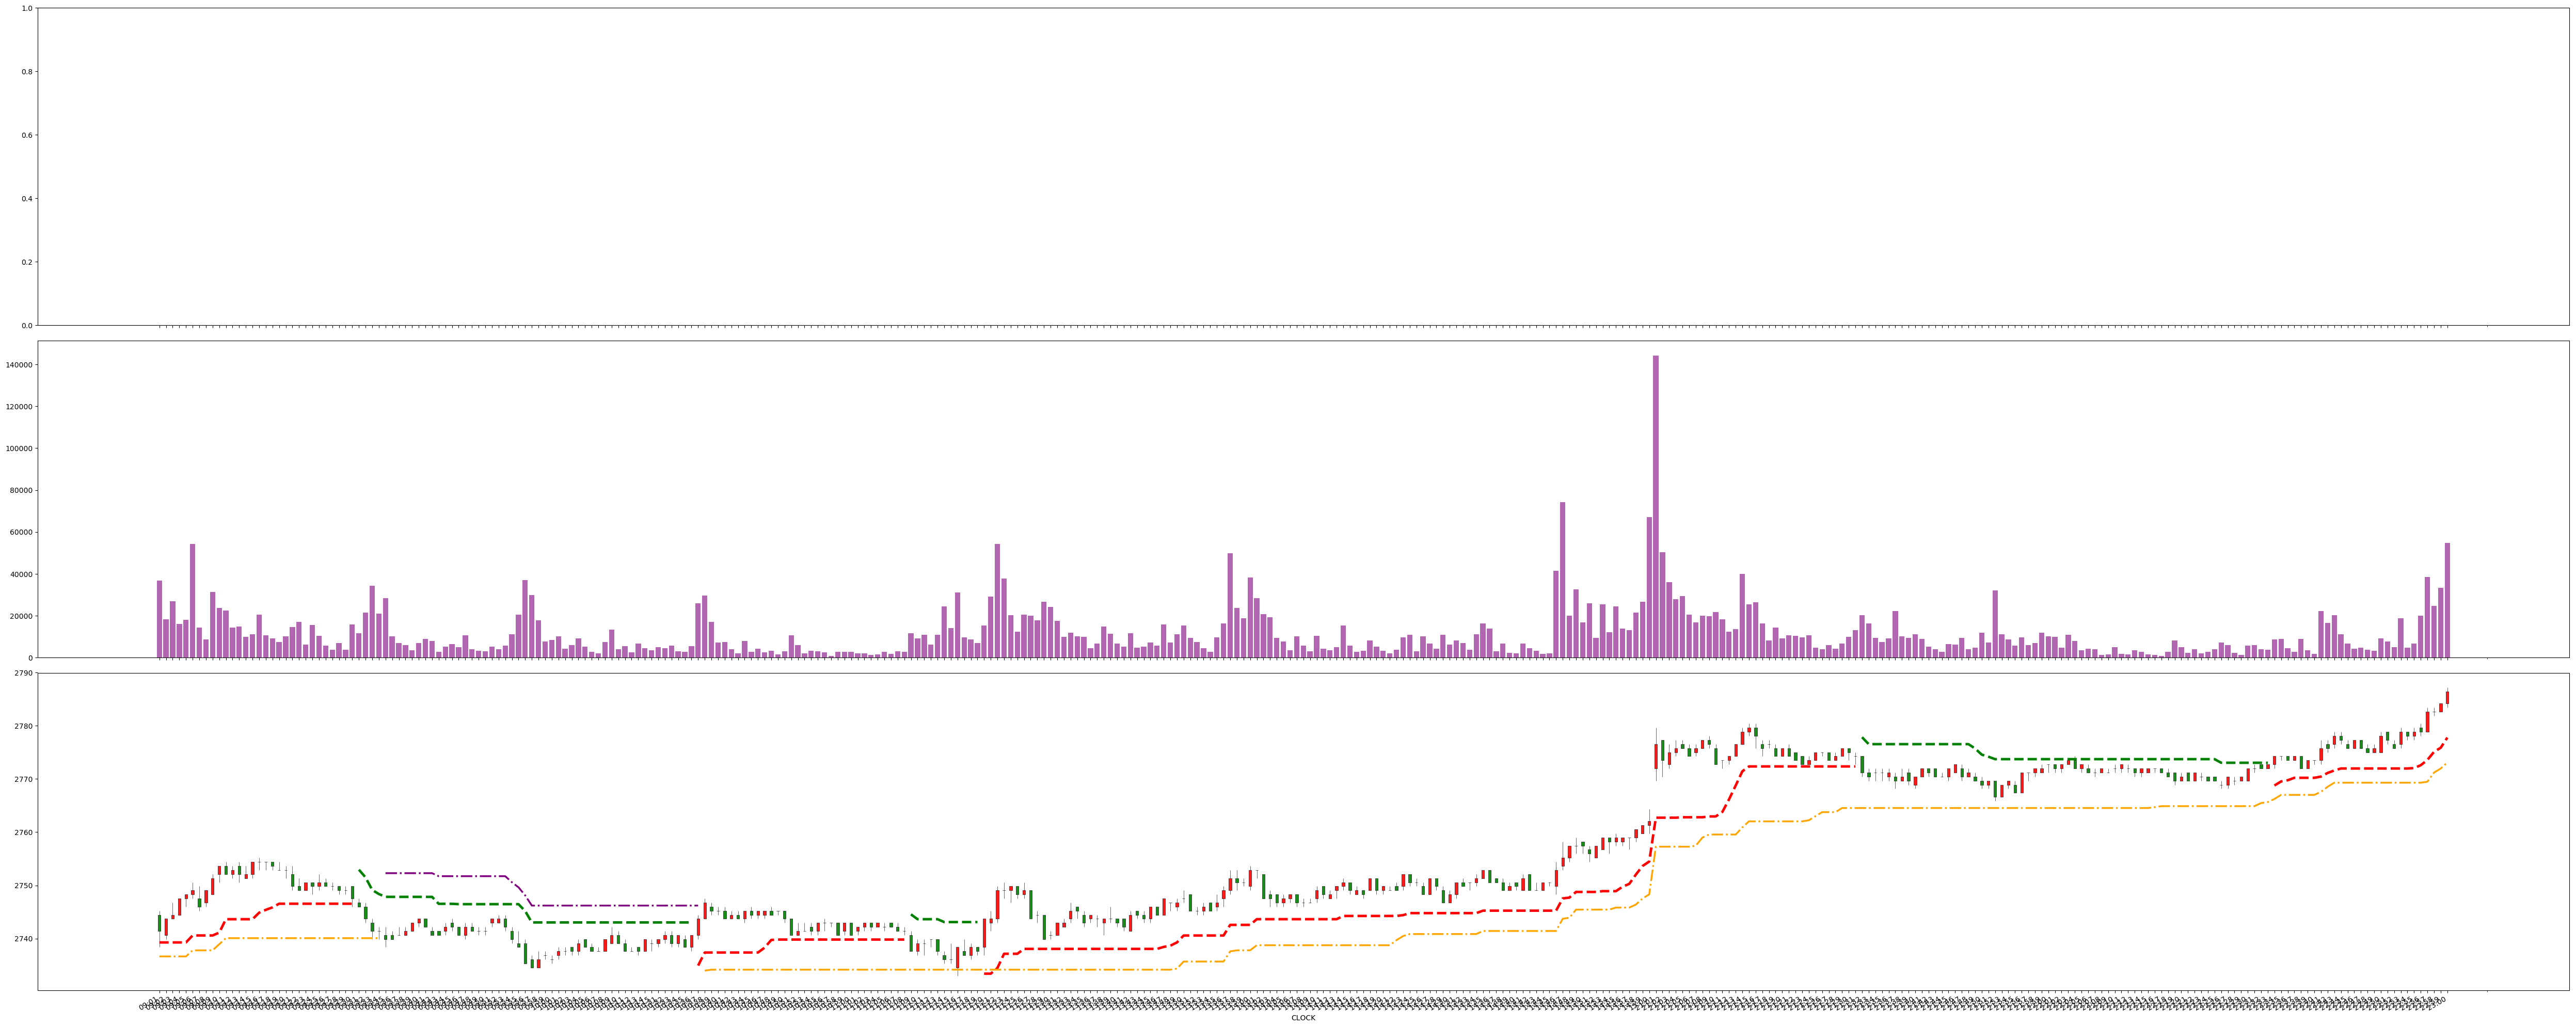

In [ ]:
plot_all(RB, OPEN, CLOSE)